# Chapter 5 - Indoor Scene Classification with TFLu and the Arduino Nano

In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


### Python libraries

In [2]:
import numpy as np
import pathlib
#!export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
import tensorflow as tf
from learning_rate_schedulers import StepDecay
#import tensorflow_model_optimization as tfmot
#import tensorflow_datasets as tfds
import zipfile
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

2023-07-14 11:56:13.428782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Constants

In [3]:
MODEL_ALPHA = 0.35
MODEL_INPUT_WIDTH = 64
MODEL_INPUT_HEIGHT = 64
TFL_MODEL_FILE = "model64outint8.tflite"
TFL_MODEL_HEADER_FILE = "model64outint8.h"
TF_MODEL = "model64outint8"

## Transfer learning with Keras

### Unzip the dataset (dataset.zip) SKIP THIS STEP


In [142]:
# with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
#   zip_ref.extractall(".")
# data_dir = "dataset"

### Prepare the train (80%) and validation (20%) datasets

In [5]:
data_dir="edited_dataset_copy"
train_ds = tf.keras.utils.image_dataset_from_directory(
  "edited_dataset_copy",
  validation_split=0,
  # subset="training",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )

valid_ds=tf.keras.utils.image_dataset_from_directory(
  "valid_dataset",
  validation_split=0,
  # subset="validation",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )
# rescale = tf.keras.layers.Rescaling(1./255, offset= -1)


Found 115 files belonging to 3 classes.
Found 30 files belonging to 3 classes.


### Get the name of the classes

In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['paper', 'rock', 'scissors']


### Rescale the pixel values from [0, 255] to [-1, 1]

In [7]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset= -1)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

valid_ds   = valid_ds.map(lambda x, y: (rescale(x), y))
# val_ds   = val_ds.map(lambda x, y: (rescale(x), y))

### Import the MobileNet v2 pre-trained model

In [8]:
num_classes=3
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
base_model = MobileNetV2(input_shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3),
                         include_top=False,
                         weights='imagenet',
                         alpha=0.35)
base_model.trainable = True

feat_extr = base_model

x=feat_extr.layers[-4].output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(64)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)
outputs=tf.keras.layers.Dense(3, activation="Softmax")(x)
# outputs=tf.keras.layers.Softmax()(x)
model= tf.keras.Model(inputs=feat_extr.inputs, outputs=outputs)
# model.summary()




### Augment the input data

In [9]:
augmen = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

train_ds = train_ds.map(lambda x, y: (augmen(x), y))
# val_ds   = val_ds.map(lambda x, y: (augmen(x), y))

### Prepare the classification head

In [148]:
# global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
# dense_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

### Build the model architecture

In [149]:
# inputs = tf.keras.Input(shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3))
# x = global_avg_layer(feat_extr.layers[-1].output)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = dense_layer(x)
# model = tf.keras.Model(inputs=feat_extr.inputs, outputs=outputs)


                           

### Compile the model with a 0.0005 learning rate

In [10]:
lr = 0.0001
# initial_learning_rate = 1e-3
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=200,
#     decay_rate=0.96,
#     staircase=True)
lr_callback=tf.keras.callbacks.LearningRateScheduler(StepDecay(initAlpha=1e-3, dropEvery=20,factor=0.75))
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)

### Model summary

In [151]:
#  model.summary()

### Train the model with 10 epochs

In [11]:
history=model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=100,
  # callbacks=lr_callback,
   #callbacks=[
        # model_checkpoint_callback,
        #early_stopping_callback,
        # tensorboard_callback,
        # lr_callback, ]
)

2023-07-14 11:58:20.025500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype resource
	 [[{{node Placeholder/_19}}]]
2023-07-14 11:58:20.029219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype resource
	 [[{{node Placeholder/_18}}]]


Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.4870

2023-07-14 11:58:46.854014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [30]
	 [[{{node Placeholder/_4}}]]
2023-07-14 11:58:46.854619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [30]
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 28s 1s/step - loss: 1.0823 - accuracy: 0.4870 - val_loss: 1.6601 - val_accuracy: 0.3667
Epoch 2/100
4/4 [==============================] - 2s 418ms/step - loss: 1.1477 - accuracy: 0.4348 - val_loss: 1.5568 - val_accuracy: 0.4000
Epoch 3/100
4/4 [==============================] - 1s 233ms/step - loss: 1.0855 - accuracy: 0.4696 - val_loss: 1.4421 - val_accuracy: 0.4333
Epoch 4/100
4/4 [==============================] - 1s 231ms/step - loss: 0.9727 - accuracy: 0.5130 - val_loss: 1.3319 - val_accuracy: 0.4667
Epoch 5/100
4/4 [==============================] - 2s 395ms/step - loss: 0.9952 - accuracy: 0.5565 - val_loss: 1.2416 - val_accuracy: 0.4000
Epoch 6/100
4/4 [==============================] - 2s 553ms/step - loss: 0.8565 - accuracy: 0.5565 - val_loss: 1.1810 - val_accuracy: 0.4000
Epoch 7/100
4/4 [==============================] - 1s 304ms/step - loss: 0.8747 - accuracy: 0.5739 - val_loss: 1.1245 - val_accuracy: 0.4667
Epoch 8/100
4/4 [==========

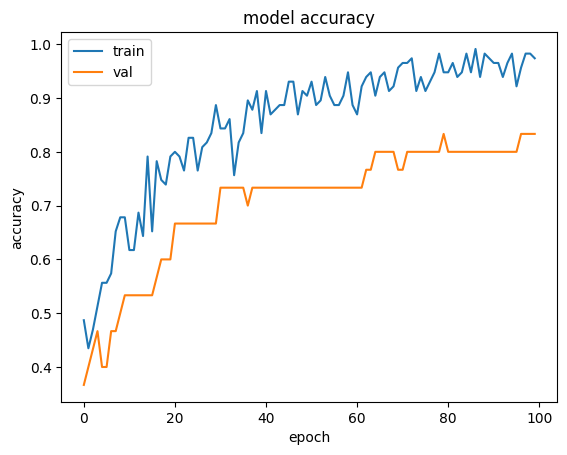

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

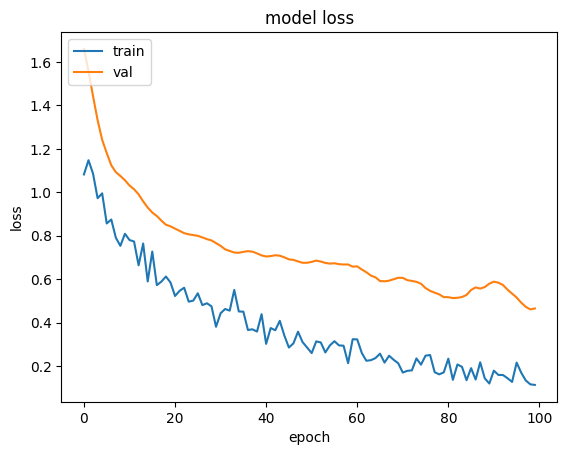

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save the TensorFlow model

In [14]:
model.save(TF_MODEL)

INFO:tensorflow:Assets written to: model64outint8/assets


INFO:tensorflow:Assets written to: model64outint8/assets


In [15]:
model=tf.keras.models.load_model(TF_MODEL)

In [16]:
import os
import cv2
# real_labels=np.concatenate([y for x, y in val_ds], axis=0)
# Folder path containing the images
folder_path = "edited_dataset_copy"  # Replace with the path to your folder
real_labels=[]
predicted_labels=[]


# Iterate over the images in the folder
for image, real_label in valid_ds:
    # if filename.endswith(".png"):  # Adjust the file extension if needed
        # Load and preprocess the image
        # image_path = os.path.join(folder_path, filename)
        # image = cv2.imread(image_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        # image = cv2.resize(image, (MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT))
        # image = image / 255.0  # Normalize the image
        # image = np.expand_dims(image, axis=0)  # Add a batch dimension
        real_labels.append(real_label)
        # Make predictions
        predicted_label = np.argmax(model.predict(image), axis=1)
        # print(predicted_label)
        # predicted_label = class_names[np.argmax(predictions)]
        predicted_labels=(predicted_label)
        # Display the image and predicted label
        # plt.imshow(image[0])
        # plt.title(f"Predicted label: {predicted_label}")
        # plt.axis("off")
        # plt.show()
sum=0
for i in range(len(np.array(real_labels)[0])):
        if np.array(real_labels)[0][i]==predicted_labels[i]:
                sum+=1

print("Accuracy: ")
print(sum/len(predicted_labels))
# print(np.array(real_labels))
# print(predicted_labels)
tf.math.confusion_matrix(np.array(real_labels)[0], predicted_labels, 3)

1/1 [==============================] - 5s 5s/step
Accuracy: 
0.8333333333333334


<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 7,  0,  3],
       [ 0,  8,  2],
       [ 0,  0, 10]], dtype=int32)>

## Preparing and testing the quantized TFLite model

### Unzip the test dataset (test_samples.zip)

In [158]:
# with zipfile.ZipFile("test_samples.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")
# test_dir = "dataset"

### Rescale the pixel values from [0, 255] to [-1, 1]

In [17]:
test_dir="edited_dataset_copy"
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      interpolation="bilinear",
                                                      image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT))
test_ds  = test_ds.map(lambda x, y: (rescale(x), y))

Found 115 files belonging to 3 classes.


### Quantize the TensorFlow model with the TFLite converter

In [20]:
repr_ds = test_ds.unbatch()

def representative_data_gen():
  for i_value, o_value in repr_ds.batch(1).take(100):
    yield [i_value]

converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8

tfl_model = converter.convert()


2023-07-14 12:07:26.847885: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-14 12:07:26.849054: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-14 12:07:26.867358: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: model64outint8
2023-07-14 12:07:26.932539: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-14 12:07:26.932919: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: model64outint8
2023-07-14 12:07:27.200028: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-14 12:07:29.118272: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: model64outint8
2023-07-14 12:07:29.598604: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 2731270 micro

### Get the TFLite model size in bytes

In [21]:
size_tfl_model = len(tfl_model)
print(len(tfl_model), "bytes")

443048 bytes


### Initialize the TFLite interpreter

In [22]:
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_content=tfl_model)

# Allocate the tensors
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Get input quantization parameters

In [24]:
# Get input/output layer information
i_details = interpreter.get_input_details()[0]
o_details = interpreter.get_output_details()[0]

# Get input quantization parameters.
i_quant = i_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]
print(i_quant)
print(i_scale)
print(i_zero_point)

{'scales': array([0.00781923], dtype=float32), 'zero_points': array([-1], dtype=int32), 'quantized_dimension': 0}
0.007819228
-1


### Evaluate the accuracy of the quantized TFLite model

In [25]:
test_ds0 = valid_ds.unbatch()

num_correct_samples = 0
num_total_samples   = len(list(test_ds0.batch(1)))

real_labels=[]
predicted_labels=[]
for i_value, o_value in test_ds0.batch(1):
  i_value = (i_value / i_scale) + i_zero_point
  i_value = tf.cast(i_value, dtype=tf.int8)
  interpreter.set_tensor(i_details["index"], i_value)
  interpreter.invoke()
  o_pred = interpreter.get_tensor(o_details["index"])[0]

  if np.argmax(o_pred) == o_value:
    num_correct_samples += 1

  real_labels.append(o_value)
  predicted_labels.append(np.argmax(o_pred))

print(tf.math.confusion_matrix(real_labels, predicted_labels, 3))
print("Accuracy:", num_correct_samples/num_total_samples)

2023-07-14 12:07:50.354878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [30]
	 [[{{node Placeholder/_4}}]]
2023-07-14 12:07:50.355563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [30]
	 [[{{node Placeholder/_4}}]]
2023-07-14 12:07:50.459553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [30]
	 [[{{

tf.Tensor(
[[ 6  0  4]
 [ 0  8  2]
 [ 0  0 10]], shape=(3, 3), dtype=int32)
Accuracy: 0.8


### Convert the TFLite model to C-byte array with xxd

In [26]:
open("model.tflite", "wb").write(tfl_model)
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i model.tflite > model64outint8.cpp

zsh:1: command not found: apt-get
